In [52]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt

import tensorflow as tf
from tf_agents.agents.dqn import dqn_agent
from tf_agents.environments import tf_py_environment
from tf_agents.networks import sequential
from tf_agents.policies import random_tf_policy
from tf_agents.policies.policy_saver import PolicySaver
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.specs import tensor_spec
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

from Dice21Env import Dice21Env


In [53]:
# Define a helper function to create Dense layers configured with the right
# activation and kernel initializer.
def dense_layer(num_units):
    return tf.keras.layers.Dense(
        num_units,
        activation=tf.keras.activations.relu,
        kernel_initializer=tf.keras.initializers.VarianceScaling(
            scale=2.0, mode='fan_in', distribution='truncated_normal'))


def collect_step(environment, policy, buffer):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)

    # Add trajectory to the replay buffer
    buffer.add_batch(traj)


def collect_data(env, policy, buffer, steps):
    for _ in range(steps):
        collect_step(env, policy, buffer)



In [58]:
print(tf.version.VERSION)

num_iterations = 20000  # @param {type:"integer"}

initial_collect_steps = 500  # @param {type:"integer"}
collect_steps_per_iteration =  1 # @param {type:"integer"}
replay_buffer_max_length = 10000  # @param {type:"integer"}

batch_size = 32  # @param {type:"integer"}
learning_rate = 1e-5  # @param {type:"number"}
log_interval = 500  # @param {type:"integer"}

num_eval_episodes = 100  # @param {type:"integer"}
eval_interval = 200  # @param {type:"integer"}



2.4.1


In [59]:
train_env = tf_py_environment.TFPyEnvironment(Dice21Env())
eval_env = tf_py_environment.TFPyEnvironment(Dice21Env())

fc_layer_params = (4, 4)
action_tensor_spec = tensor_spec.from_spec(train_env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

# QNetwork consists of a sequence of Dense layers followed by a dense layer
# with `num_actions` units to generate one q_value per available action as
# it's output.

dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03))
q_net = sequential.Sequential(dense_layers + [q_values_layer])

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

In [60]:
agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

collect_data(train_env, random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                        train_env.action_spec()), replay_buffer, initial_collect_steps)

dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2
).prefetch(3)

iterator = iter(dataset)

In [61]:
def compute_avg_return(environment, policy, num_episodes=10, debug=False):
    total_return = 0.0
    for _ in range(num_episodes):
        if debug:
            print("===== Start =====")
        time_step = environment.reset()
        episode_return = 0.0
        step_count = 0
        while not time_step.is_last():
            if debug:
                print(f"observation: {time_step.observation}")
            step_count += 1
            action_step = policy.action(time_step)
            if debug:
                print(f"action: {action_step.action.numpy()[0]}")
            time_step = environment.step(action_step.action)
            if debug:
                print(f"reward: {time_step.reward*21}")
            episode_return += time_step.reward
        total_return += episode_return
        if debug:
            print("===== END =====")


    _avg_return = total_return / num_episodes
    return _avg_return.numpy()[0]

In [81]:

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]
best_return = 0

for x in range(num_iterations):
    # Collect a few steps using collect_policy and save to the replay buffer.
    collect_data(train_env, agent.collect_policy, replay_buffer, collect_steps_per_iteration)

    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss
    step = agent.train_step_counter.numpy()

    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
        if avg_return > best_return:
            best_return = avg_return
            saver = PolicySaver(agent.policy, batch_size=None)
            saver.save('policy')

        print('step = {0}: Average Return = {1}'.format(step, avg_return*21))
        returns.append(avg_return)

INFO:tensorflow:Assets written to: policy/assets


INFO:tensorflow:Assets written to: policy/assets


step = 200: Average Return = 12.705806493759155


In [80]:
res = compute_avg_return(eval_env, tf.compat.v2.saved_model.load('policy'), 20, True)
res*21


===== Start =====
observation: [[0 0]]
action: 1
reward: [0.021]
observation: [[5 5]]
action: 1
reward: [0.021]
observation: [[8 8]]
action: 1
reward: [0.021]
observation: [[10 10]]
action: 1
reward: [0.021]
observation: [[12 12]]
action: 1
reward: [0.021]
observation: [[18 18]]
action: 0
reward: [18.]
===== END =====
===== Start =====
observation: [[0 0]]
action: 1
reward: [0.021]
observation: [[4 4]]
action: 1
reward: [0.021]
observation: [[5 5]]
action: 1
reward: [0.021]
observation: [[7 7]]
action: 1
reward: [0.021]
observation: [[9 9]]
action: 1
reward: [0.021]
observation: [[15 15]]
action: 1
reward: [0.021]
observation: [[18 18]]
action: 0
reward: [18.]
===== END =====
===== Start =====
observation: [[0 0]]
action: 1
reward: [0.021]
observation: [[6 6]]
action: 1
reward: [0.021]
observation: [[8 8]]
action: 1
reward: [0.021]
observation: [[9 9]]
action: 1
reward: [0.021]
observation: [[10 10]]
action: 1
reward: [0.021]
observation: [[14 14]]
action: 1
reward: [0.021]
observation

18.407099783420563

(-14.016210025548935, 25.0)

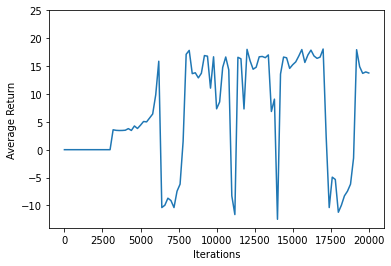

In [79]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=25)